# Shiftr: Simple, Clean Image Shifting Fun

First, run the cell below. You can do that using shift+Enter, or Cell>Run

In [2]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.ndimage.interpolation import shift
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from IPython.display import display

def plot_shift(im0, im, shift_y,shift_x):
    s=shift(im, [shift_y,shift_x])
    diff=s-im0
    fig, ax=plt.subplots(figsize=(12,8))
    ax.imshow(diff, cmap=plt.cm.bwr, clim=[-40,40])

Then run this cell to navigate to the correct directory on LINNA, or change it to point to a local directory on your computer. You should use the folder which contains two folders, Background and Shot. I do this by navigating to the folder using Explorer, then clicking the folder icon to the left of the path, which converts the path to text that you can copy and paste.

In [1]:
cd "\\linna\Users\Magpie\Documents\MAGPIE data\2015\August_2015\s0821_15 Bow shocks Al grid\s0821_15 12-frame"

\\linna\Users\Magpie\Documents\MAGPIE data\2015\August_2015\s0821_15 Bow shocks Al grid\s0821_15 12-frame


Run the cell below to load the data. Backgrounds should be .jpg. Shots should be .tif. Both must be in separate folders called eg. "s0821_15 Background" and "s0821_15 Shot" and the files should be labeled eg "s0821_15 Shot_001"

In [3]:
shot=os.path.split(os.getcwd())[-1][0:8] #automatically grab the shot number
b=[]
s=[]
for i in range(1,13):
    if i<10:
        st="0"+str(i)
    else:
        st=str(i)
    im=plt.imread(shot+" Background/"+shot+" Background_0"+st+".jpg")
    b.append(np.asarray(np.sum(im,2), dtype=float))
    im=plt.imread(shot+" Shot/"+shot+" Shot_0"+st+".tif")
    s.append(im)

bb=np.zeros((13, b[0].shape[0], b[0].shape[1])) #create an empty array to store the results
ss=np.zeros((13, s[0].shape[0], s[0].shape[1]))
bb[0]=b[0]
ss[0]=s[0]
shifts=np.zeros((13,2))

Change 'image' to be the desired image. Images are labelled from 1. You don't need to adjust image 1! 
Then run this cell. Use the sliders to achieve the best overlap.

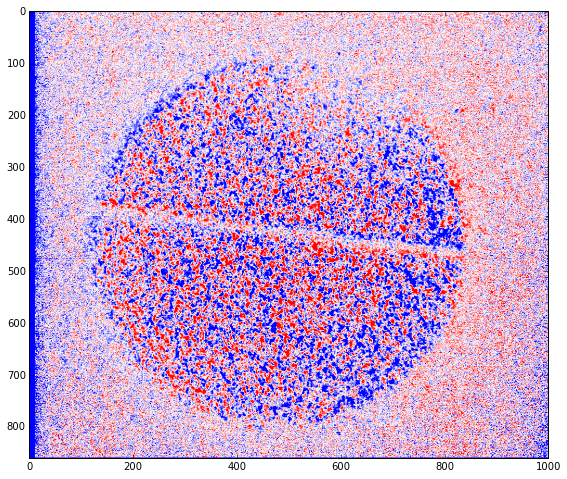

In [4]:
image=2
sy=widgets.FloatSlider(min=-20,max=20,step=0.5,value=0)
sx=widgets.FloatSlider(min=-20,max=20,step=0.5,value=0)
w=interactive(plot_shift, im0=fixed(b[0]), im=fixed(b[image-1]), shift_y=sy, shift_x=sx)
display(w)

Once you are happy with the overlap, run the cell below to shift the shot image. Then change 'image' in the cell above, run it, and repeat this step until all images have been shifted.

In [5]:
tx, ty=w.kwargs['shift_x'], w.kwargs['shift_y']
shifts[image-1]=(ty,tx)
bb[image-1]=sp.ndimage.shift(b[image-1], [ty,tx])
ss[image-1]=sp.ndimage.shift(s[image-1], [ty,tx])

Change to the directory you want to put the files to.

In [6]:
cd "C:\Users\jdavies\Google Drive\MAGPIE\data\2015"

C:\Users\jdavies\Google Drive\MAGPIE\data\2015


Finally, run this cell below to save out all of the shifted background and shot images.

In [7]:
for i in range(0,12):
    if i<10:
        st="0"+str(i+1)
    else:
        st=str(i+1)
    bkfn=shot+" Background_0"+st+".png"
    shfn=shot+" Shot_0"+st+".png"
    sp.misc.toimage(bb[i], cmin=bb[i].min(), cmax=bb[i].max()).save(bkfn)
    sp.misc.toimage(ss[i], cmin=ss[i].min(), cmax=ss[i].max()).save(shfn)    